In [417]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer


import torch
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic Regression Implementation

### Experiments

### Vanilla Gradient Descent

In [418]:
# generate data for classification problem
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):   
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

In [419]:
# function to plot classification data
def plotter(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["*" , "o"]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "jet", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

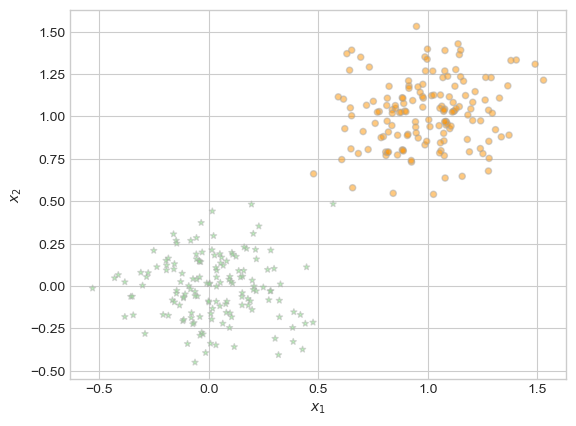

In [420]:
X, y = classification_data(noise = 0.2)
fig, ax = plt.subplots(1,1)
plotter(X,y,ax)

In [421]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

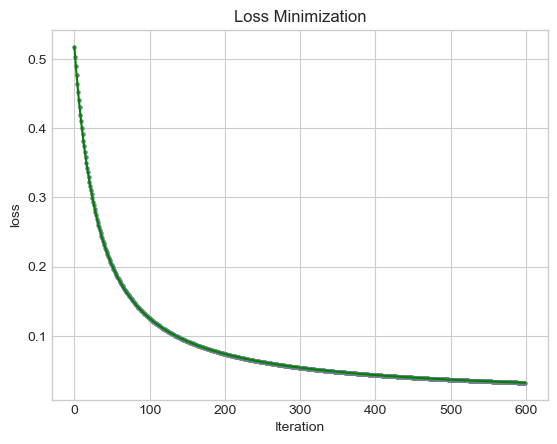

In [422]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

# training loop
for index in range(600):
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.3, beta = 0)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

# save final weights for graphing decision boundary
final_weights = LR.w
    
def plot_loss(loss_vec):
    plt.plot(loss_vec, color = "green")
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s = 5)
    plt.gca().set(xlabel = "Iteration", ylabel = "loss")
    plt.title("Loss Minimization")

plot_loss(loss_vec)

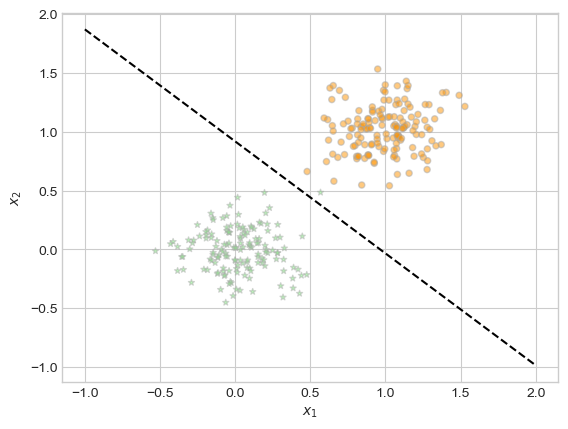

In [423]:
fig, ax = plt.subplots(1,1)
plotter(X, y, ax)
draw_line(final_weights, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

### Benefits of Momentum

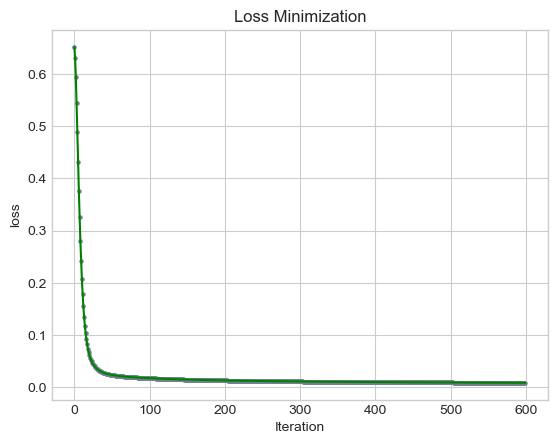

In [424]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

# training loop
for index in range(600):
    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    opt.step(X, y, alpha = 0.3, beta = 0.9)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

# save final weights for graphing decision boundary
final_weights = LR.w

plot_loss(loss_vec)

### Overfitting

In [425]:
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

In [426]:
# initialize an instance of Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

# training loop
for index in range(100):
    opt.step(X_train, y_train, alpha = 0.3, beta = 0)

In [427]:
# Accuracy on training data
(1.0*(LR.predict(X_train) == y_train)).mean()

tensor(1.)

In [428]:
# Accuracy on testing data
(1.0*(LR.predict(X_test) == y_test)).mean()

tensor(0.9600)